In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

코랩 사용하시는 분들은 아래의 코드를 실행해주세요!

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import os
# os.getcwd()

코랩 사용시 본인 구글 드라이브 경로는  
/content/drive/MyDrive/...  
입니다.

In [4]:
# path = './drive/MyDrive/...'    # 과제 데이터셋이 저장된 경로를 더 작성해주세요
# os.chdir(path)

In [5]:
# os.getcwd()

사용할 데이터 셋 :  전력 사용량 예측 모델

아래의 과정에서 sklearn의 Pipeline의 사용은 필수는 아닙니다. 선호와 필요에 따라 사용하실 분들은 사용하셔도 좋습니다.

# 데이터

건물 정보와 기후 정보를 활용한 전력사용량 예측 데이터 중에서 

환경 변수(기온, 풍속, 습도, 강수량, 일조)에 대해 전력 사용량을 선형회귀 모델을 사용해서 예측해보고자 합니다.

In [6]:
var_name = ['Temp', 'Wind', 'Moisture', 'Precipitation', 'Sun']
target = 'Wh'

In [7]:
def parsing(data: pd.DataFrame):
    x = data.iloc[:, 3:8]
    x.columns = var_name
    y = data.iloc[:, 2]
    y.name = target
    
    return x, y

In [8]:
def load_data():
    data = pd.read_csv('data/train.csv', encoding='cp949')
    data = data[: 100]
    x, y = parsing(data)    
    cut = int(round(len(x)*0.88))
    tr_x = x[:cut]
    tr_y = y[:cut]
    te_x = x[cut:]
    te_y = y[cut:]
    return tr_x, tr_y, te_x, te_y

In [9]:
train_x, train_y, test_x, test_y = load_data()

## 데이터 확인 

주의! 최종 예측하는 단계 이전에는 현재 가지고 있는 데이터, 즉 train data만을 이용하여 작업을 진행해야 합니다.

현재 가지고 있는 데이터 train_x를 보고 전력 사용량을 예측하는데에 사용할 변수를 선택해주세요.

기초세션에서 다뤘던 내용을 참고하셔서 최적의 변수 조합을 찾아보도록 합시다.

이 때 선택해야하는 변수는 하나일 수도 있고, 여러개의 변수를 사용하여도 좋습니다.

In [10]:
train_x

,Temp,Wind,Moisture,Precipitation,Sun
0,17.6,2.5,92.0,0.8,0.0
1,17.7,2.9,91.0,0.3,0.0
2,17.5,3.2,91.0,0.0,0.0
3,17.1,3.2,91.0,0.0,0.0
4,17.0,3.3,92.0,0.0,0.0
...,...,...,...,...,...
83,23.9,2.8,68.0,0.0,0.6
84,25.0,3.1,63.0,0.0,0.8
85,26.0,3.1,60.0,0.0,1.0
86,26.4,3.8,60.0,0.0,1.0


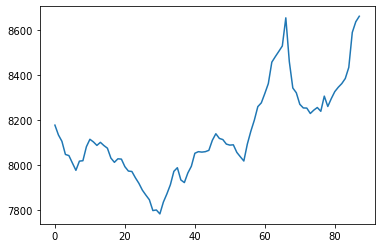

In [11]:
plt.plot(train_y)

In [12]:
corr = pd.DataFrame(np.concatenate((train_x, train_y[:, np.newaxis]), axis=1), columns=var_name+[target]).corr()
corr

C:\Users\ay011\AppData\Local\Temp/ipykernel_868/1635138233.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  corr = pd.DataFrame(np.concatenate((train_x, train_y[:, np.newaxis]), axis=1), columns=var_name+[target]).corr()


,Temp,Wind,Moisture,Precipitation,Sun,Wh
Temp,1.000000,0.510935,-0.628642,-0.173210,0.783829,0.803301
Wind,0.510935,1.000000,-0.478825,0.028617,0.544720,0.349288
Moisture,-0.628642,-0.478825,1.000000,0.152529,-0.699047,-0.095042
Precipitation,-0.173210,0.028617,0.152529,1.000000,-0.123846,-0.090389
Sun,0.783829,0.544720,-0.699047,-0.123846,1.000000,0.458348
Wh,0.803301,0.349288,-0.095042,-0.090389,0.458348,1.000000


In [13]:
variables = ['Temp', 'Wind', 'Sun']

In [14]:
train_x = train_x[variables]
train_x

,Temp,Wind,Sun
0,17.6,2.5,0.0
1,17.7,2.9,0.0
2,17.5,3.2,0.0
3,17.1,3.2,0.0
4,17.0,3.3,0.0
...,...,...,...
83,23.9,2.8,0.6
84,25.0,3.1,0.8
85,26.0,3.1,1.0
86,26.4,3.8,1.0


정답은 없습니다! 

다만 최종 선택한 변수(들)이 왜 선택받았는지 간단히 알려주세요.<br>
답변 : Wh를 기준으로 corr값을 보았을 때 작지 않은 값을 가지고 있다. 다만 Temp와 Wind, Sun 간에도 작지 않은 corr으로 인한 영향도 무시하지 못하지만, 데이터 확인 단계에서 충분한 설명력을 가진 모델을 위해 세 변수들을 사용하기로 한다.

## 전처리

위에서 선택한 변수들(feature)를 가지고 한번 전력 사용량을 예측하는 모델을 만들어 보기에 앞서,

**train 데이터의 feature의 전처리**를 진행해보려고 합니다. StandardScaler를 사용하셔도 좋고, MinMaxScaler를 사용하셔도 좋습니다! 

또한 PolynomialFeatures를 이용하거나 직접 feature를 계산하여 고차원의 feature를 만드셔도 좋습니다. 이 또한 정답은 없습니다!

이 때 최종 train_x의 shape은 (n_samples, n_features)가 되도록 해주세요.<br>
ex. 4개의 변수를 가진 1000개의 샘플의 경우 train_x.shape은 (1000,4)가 되면 됩니다.

특히 하나의 변수만을 사용하시는 분들은 1D가 아닌 2D가 되도록 신경써주세요<br>
ex. train_x.shape이 (1000,)이 아닌 (1000,1)입니다!

In [15]:
# 사용할 패키지를 import!
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

In [16]:
scaler = MinMaxScaler().fit(train_x)
train_x = scaler.transform(train_x)

In [17]:
def sinusoidal(data):
    return np.concatenate((data, np.sin(data)), axis=1)

In [18]:
train_x = sinusoidal(train_x)

어떤 변수들을 더 사용할지에 대해 고민하였을 때 앞서 train_y에 대한 plot에서도 알 수 있듯 값의 변화가 단순한 선형적인 관계보단 주기함수로 표현될 수 있다고 생각하여 추가해본 변수다. 이 외에 다른 polynomial feature들을 사용할 근거를 찾지 못해 사용하지 않았다.

# 모델링

## 학습 

이제 모델링을 해봅시다.

앞서 다룬 여러 regression 모델들(Linear regression, Ridge Regression, Lasso Regression, ..)을 이용해서 fit을 진행해보도록 합시다.

In [19]:
# 사용할 패키지를 import!
from sklearn.linear_model import Ridge

In [20]:
# 선형회귀 모델 생성 후 fitting 시킵니다.
# ex. 
model = Ridge(random_state=123).fit(train_x, train_y)

## 추정

이제 train_x를 이용하여 전력사용량을 추정해보도록 합시다.

In [21]:
# ex. linear_pred_y 
esti_y = model.predict(train_x)

# Loss 및 시각화

앞서 fitting하여 얻은 모델을 이용하여 추정한 값으로 MSE를 측정해봅시다. 변수를 하나만 사용하신 분들은 xy 평면에 한번 같이 시각화도 해보셔도 좋습니다.

In [22]:
def mse(pred, true):
    return np.mean((pred-true)**2)

In [23]:
train_mse = mse(esti_y, train_y)
print(f"Linear {train_mse:.5f}")

Linear 12774.93566


In [24]:
def visualize(model, x, y):
    if x.shape[1] != 1:
        return None
    beta = model.coef_[0]
    intercept = model.intercept_
    
    x_axis = np.linspace(np.min(x), np.max(x), 100)
    fit = intercept * x_axis**0 + beta*x_axis 

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, fit, label='Predict', c='r', linewidth=3)
    plt.scatter(x, y, c='blue')
    plt.legend()
    plt.show()

In [25]:
# # 앞서 전처리한 변수를 한번 확인해봅시다.
# train_x
# train_y 

In [26]:
# # visualization 하실 분은 진행해주세요!
# visualize(model, train_x, train_y)

# 예측

테스트셋에 대해서 한번 **예측**해보도록 합시다.

이미 fitting된 모델 (그리고 scaler를 사용하신다면 scaler)에 대해 **fit을 하지 말고** 단순히 predict만 진행해보도록 합시다. 

scaler는 transform만 하시고 model은 predict을 진행해주세요

In [27]:
# transform을 하시는 분들은 실행해주세요
test_x = test_x[variables]
test_x = scaler.transform(test_x)
test_x = sinusoidal(test_x)

In [28]:
# y1_hat에 predict값 할당
pred_y =  model.predict(test_x)

# 성능 평가

한번 학습한 모델에 대해 test_y를 이용하여 mse loss를 측정해도도록 합시다.

In [29]:
def score(train_mse, test_mse):
    print(f"{test_mse/train_mse: .4f}")

In [30]:
test_mse = mse(pred_y, test_y)
print(f"Linear {test_mse:.5f}")

Linear 169111.42791


In [31]:
score(train_mse,test_mse)

 13.2378


In [32]:
model.coef_

array([419.59639992,   0.93933108, -80.5067218 , 348.45996166,
        20.40294639, -31.54129743])

In [33]:
# visualization 하실 분은 진행해주세요!
# visualize(model, test_x, test_y)

# 그 이후

이제 여러분들은 한번 모델을 만들어보고 fitting한 다음 예측까지 해보셨습니다.

이제 개선하기 위해 1.데이터부터 5.성능평가 중 수정, 변경하실 부분을 업데이트 해서  최적의 모델을 찾아보세요!

현재 사용하고 있는 scaler, model부터 전처리과정 기타 여러 조건을 조작해보시고 어떤 효과가 있는지 한번 보시고 알려주세요:D

고생하셨습니다!

# 최종 코멘트

현재 여러가지 방법으로 접근해서 해결해보는 관점들이 있었고, 훌륭한 인사이트들도 많았습니다. 다소 난해한 과제이지만 수행해주셔서 감사합니다! 특히 정답이 정해져 있지 않은 과제인 만큼 각자의 논리와 방식대로 수행하시면서 얻어가는 부분이 많이 있으시길 바랍니다.

우선 정답이 없는 만큼 해당 과제에서 의도한 부분이 무엇이었는지, 한번 생각해보시면 좋은 부분이 뭔지 얘기해보면 좋을 것 같습니다.

> 데이터 자체를 의심해보시는 시간도 의미있습니다.

현재 모델을 어떻게 만들고 학습 시키는지에 대해서는 패키지에 의존하기도 하며 이미 잘 구현된 모델을 가져와 사용하시는 것에 대해서 저희가 가져갈 수 있는 포인트는 적다고 생각합니다. 직접 학습과정을 구현해보는 과제가 아닌 이상 모델을 어떻게 만들었는지보단, 각 모델들이 어떤 특징이 있고 그 특징을 필요하다면 사용하실 수 있는 것만으로도 충분히 좋은 경험이라고 생각합니다. 

그렇기 때문에 이번 과제에서는 데이터 자체를 의심하고 고민해보시는 시간이 되길 바랐습니다. 데이터의 주어진 train 데이터와 test 데이터에도 구조적으로 차이가 있기 때문에 단순히 MSE나 다른 수치만을 보고 판단하시기에 어려움이 있으셨을 것이라 생각합니다. 그렇기 때문에 데이터가 어떻게 되어 있는지 생각해볼 필요가 있다는 점을 가져가신다면 좋은 경험이라 생각합니다.

> 어떤 모델이 좋은 모델인지 생각해볼 시간도 의미있습니다.

score함수로 제공해드린 것은 아마 생소한 식이라고 느끼셨을 것이라 생각합니다. 해당 식의 의미가 무엇인지, 어떤 해석이 가능한지 고민해볼 기회가 되었으면 충분히 과제를 매우 깊은 단계까지 진행하셨다고 생각합니다. 우선 해당 score에서 단순히 많은 변수를 사용한다고 하였을 때 데이터의 구조상 train데이터에 대한 mse 값은 상대적으로 test 데이터에 비해 매우 작게 나올 것입니다. 그런 경우 해당 모델이 좋은 모델인지, 좋지 않은 모델인지 각자만의 논리로 판단해보시는 기회가 된다고 생각합니다. 반대로 train데이터의 mse와 test 데이터의 mse가 비슷비슷한 크기를 가진다고 할 때 적절히 학습하였기에 둘 다 적절한 크기를 가지고 있는 것인지, 혹은 trian 데이터에 대해서도, test 데이터에 대해서도 모두 poor한 fit을 가지고 있는 것인지 고민해보실 기회가 된다고 생각합니다. 

무엇보다도 중요한 점은 정답은 없습니다. 그리고 이후로도 정답을 알려주는 문제나 모델은 없을 것입니다. 각 상황에서 어떻게 판단하고 해결할지 고민해보는 시간에 도움이 되는 과제가 되었길 바랍니다.

감사합니다.